In [162]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from numpy import mean
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    auc,
    make_scorer,
    confusion_matrix,
)
from sklearn.pipeline import make_pipeline
from IPython.display import Markdown
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

In [163]:
import warnings

warnings.filterwarnings("ignore")

In [164]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("pastel")

# Import Data

In [165]:
application_test = pd.read_csv("data/application_test.csv")
application_train = pd.read_csv("data/application_train.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
bureau = pd.read_csv("data/bureau.csv")
credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
home_credit_columns_description = pd.read_csv(
    "data/HomeCredit_columns_description.csv")
installments_payments = pd.read_csv("data/installments_payments.csv")
pos_cash_balance = pd.read_csv("data/POS_CASH_balance.csv")
previous_application = pd.read_csv("data/previous_application.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

We will start by looking at a sample of the different datasets, describing each feature and plotting the ones that contain missing values

In [166]:
def plot_missing_data(df, name):
    plt.figure(figsize=[15, 3])
    columns_with_missing_data = df.columns[df.isnull().any()]
    df[columns_with_missing_data].isna().mean().plot(kind="bar")
    plt.title(f"{name} features that contain missing values")
    plt.ylabel("Proportion of Missing Values")
    plt.xticks(rotation=75, ha="right")
    plt.show()


def describe_with_nan_count(df):
    summary = df.describe(include="all")
    summary.loc["nan_count"] = df.isna().sum()
    display(summary)


def summarize_dataset(datasets):
    for name, set in datasets.items():
        null_percentage = set.isna().mean().mean() * 100
        display(Markdown(f"## {name}"))
        display(
            Markdown(
                f" Shape: {str(set.shape)}, Null Values: {str(round(null_percentage, 1))}%"
            )
        )
        display(set.sample(2))
        describe_with_nan_count(set)
        if null_percentage > 0:
            plot_missing_data(set, name)
        print("\n")

#### Current Application

## Application Test

 Shape: (48744, 121), Null Values: 23.8%

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
15150,209116,Cash loans,M,N,Y,0,58500.0,238500.0,12937.5,238500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
41274,403315,Cash loans,M,Y,Y,1,270000.0,582804.0,29884.5,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48305,32678,32311,33658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,277796.676350,NaN,NaN,NaN,NaN,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,NaN,NaN,NaN,NaN,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,NaN,NaN,NaN,NaN,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,NaN,NaN,NaN,NaN,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,NaN,NaN,NaN,NaN,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


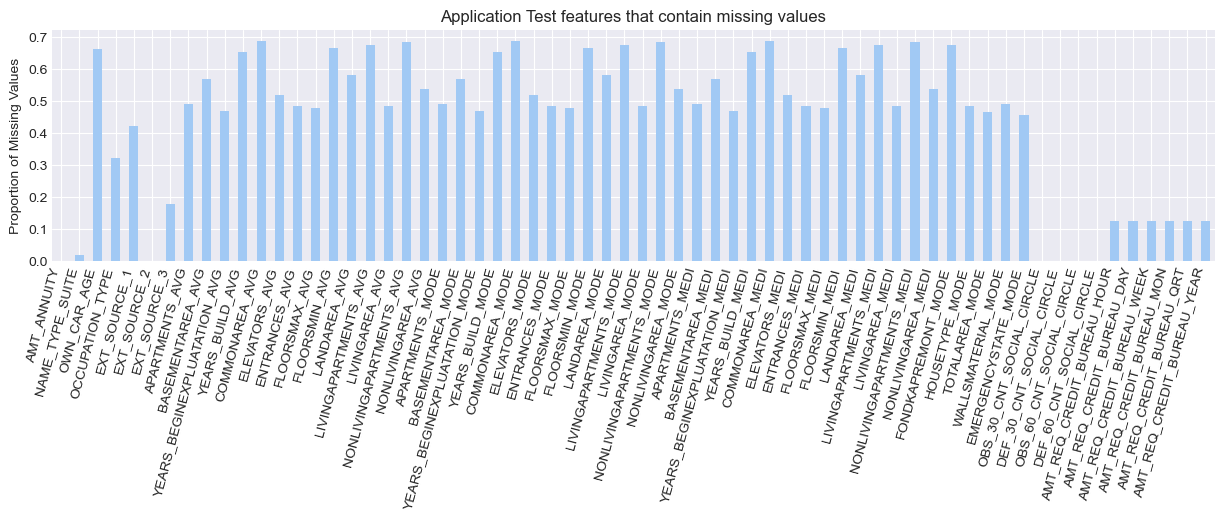

## Application_ Train

 Shape: (307511, 122), Null Values: 24.4%

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
67711,178524,0,Cash loans,F,Y,Y,0,202500.0,1205896.5,35388.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
12788,114908,0,Cash loans,F,N,N,0,112500.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


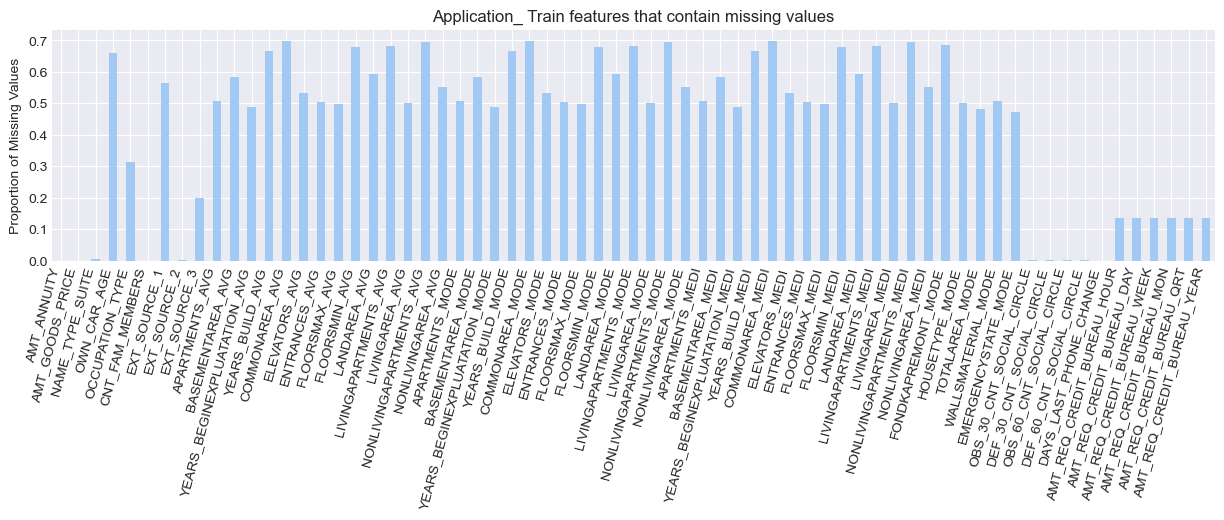

In [167]:
summarize_dataset(
    {
        "Application Test": application_test,
        "Application_ Train": application_train,
    }
)

Application train and test contain the same features, with the exception of target. They contain information about each loan application at Home Credit. 

The Application Train contains the Target feature and will be used to train the model. The test set does not contain a Target feature and will be used to evaluate the model.
Target = 0 means that the loan was repaid, 1 means it wasn't. 



#### Previous Application

## Previous Application

 Shape: (1670214, 37), Null Values: 18.0%

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
627960,1677738,448321,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,12,...,Connectivity,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
709485,1534771,447153,Revolving loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,6,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,...,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,...,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,...,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,...,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,...,NaN,1.456729e+01,NaN,NaN,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,...,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,...,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,...,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,...,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


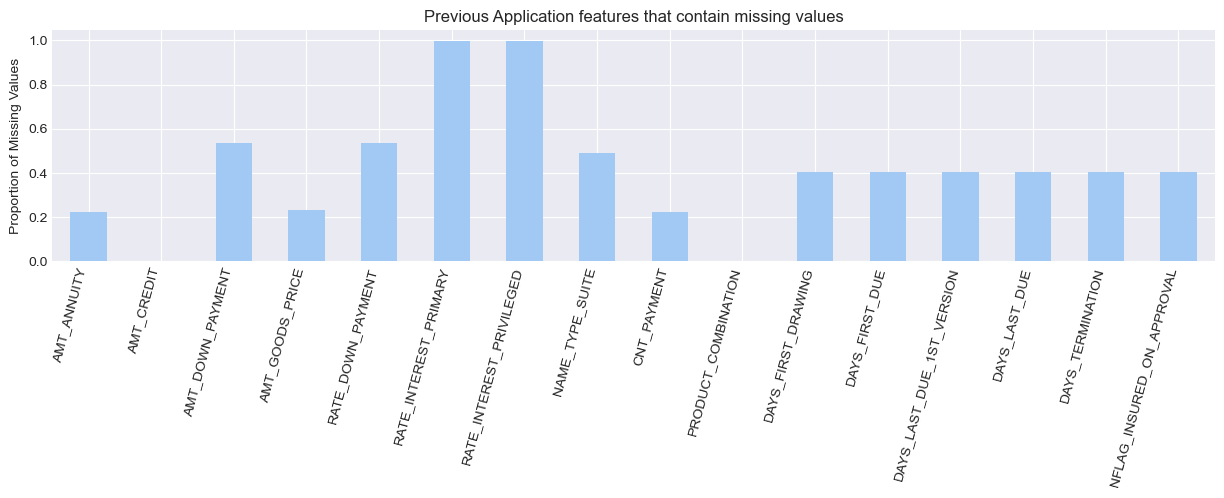

## Installments Payments

 Shape: (13605401, 8), Null Values: 0.0%

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3214527,1213475,160907,1.0,15,-775.0,-786.0,41264.37,1762.56
10641748,2347340,399427,1.0,1,-1820.0,-1832.0,23648.67,23648.67


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06
nan_count,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.905000e+03,0.000000e+00,2.905000e+03


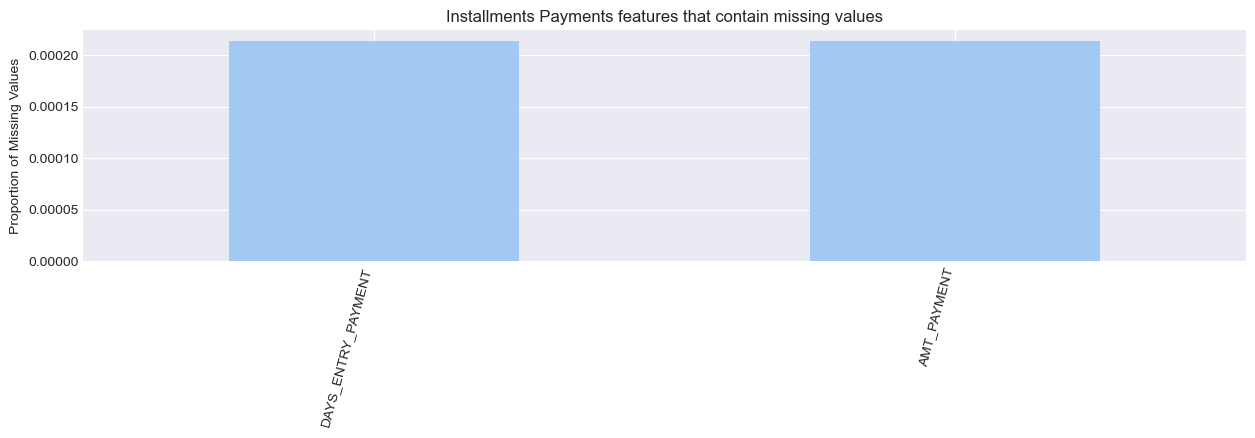

In [168]:
summarize_dataset(
    {
        "Previous Application": previous_application,
        "Installments Payments": installments_payments,
    }
)

Previous_application contain information regarding a client's previous application prior to the current loan.

Installment_payment contain information regarding a client's previous loans payment history. 

#### Bureau datasets

## Bureau

 Shape: (1716428, 17), Null Values: 13.5%

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
165129,250636,6254520,Closed,currency 1,-1232,0,-896.0,-896.0,139.5,0,607216.5,NaN,NaN,0.0,Consumer credit,-704,NaN
325427,213934,5537129,Active,currency 1,-316,0,NaN,NaN,NaN,0,90000.0,84762.0,NaN,0.0,Credit card,-19,8887.5


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


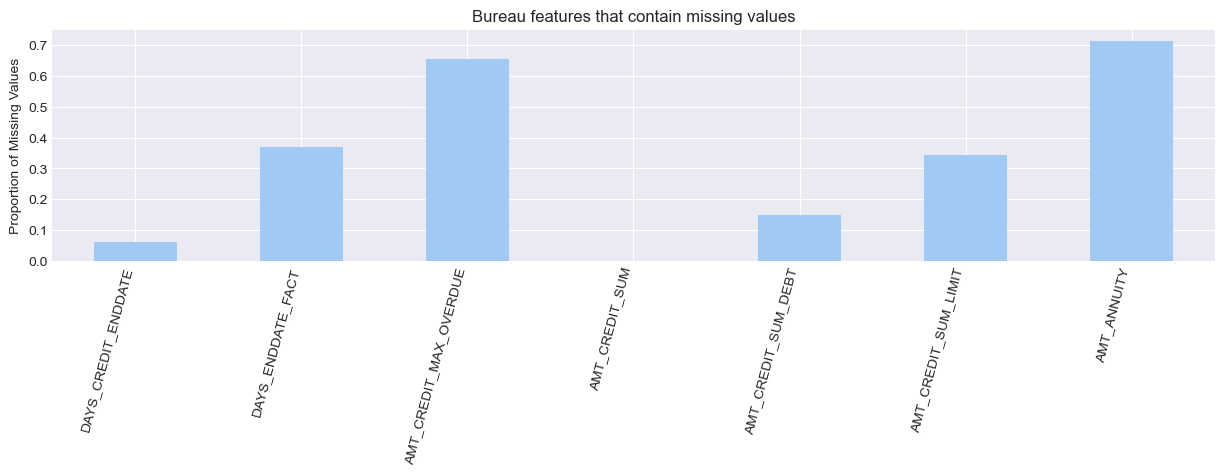

## Bureau Balance

 Shape: (27299925, 3), Null Values: 0.0%

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
7535834,5142110,-76,0
9446654,6423876,-15,X


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


In [169]:
summarize_dataset(
    {
        "Bureau": bureau,
        "Bureau Balance": bureau_balance,
    }
)

Bureau dataset contain information regarding a client's prior credit information. A client can have multiple previous credits. 

Bureau_balance breaks down credit information month by month 

#### Credit Card and Cash Loans

## Credit Card Balance

 Shape: (3840312, 23), Null Values: 6.7%

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
61171,1642748,352717,-71,278166.240,270000,2250.0,2250.0,0.0,0.0,13500.0,...,278166.240,278166.240,1.0,1,0.0,0.0,12.0,Active,0,0
3577147,1819974,255454,-72,64733.805,135000,0.0,0.0,0.0,0.0,6750.0,...,64733.805,64733.805,0.0,0,0.0,0.0,20.0,Active,0,0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


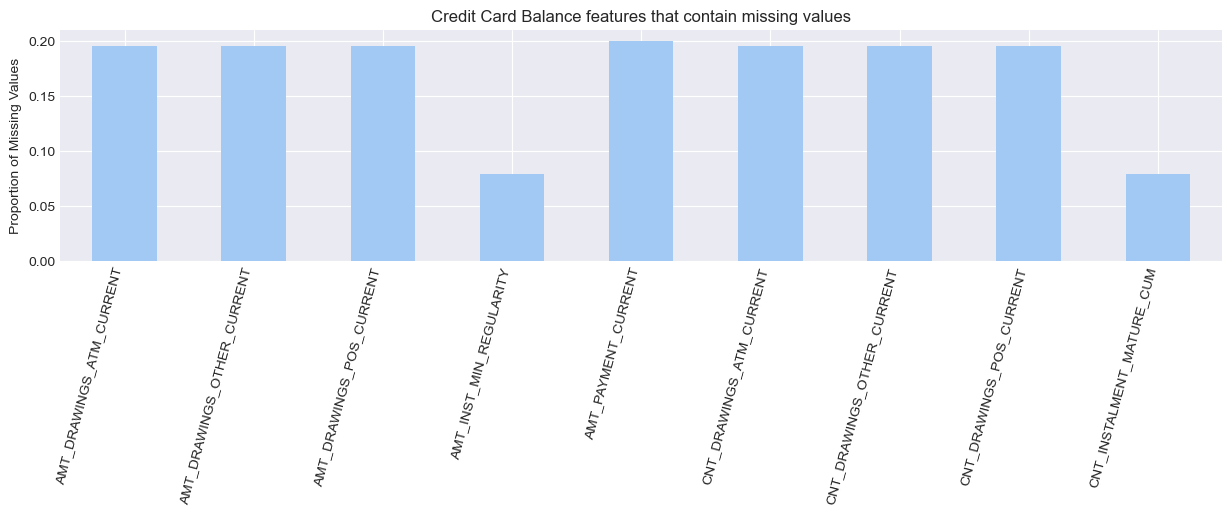

## Pos Cash Balance

 Shape: (10001358, 8), Null Values: 0.1%

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9327479,1670359,201180,-1,12.0,1.0,Active,0,0
6063090,2523538,402246,-55,24.0,24.0,Active,0,0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


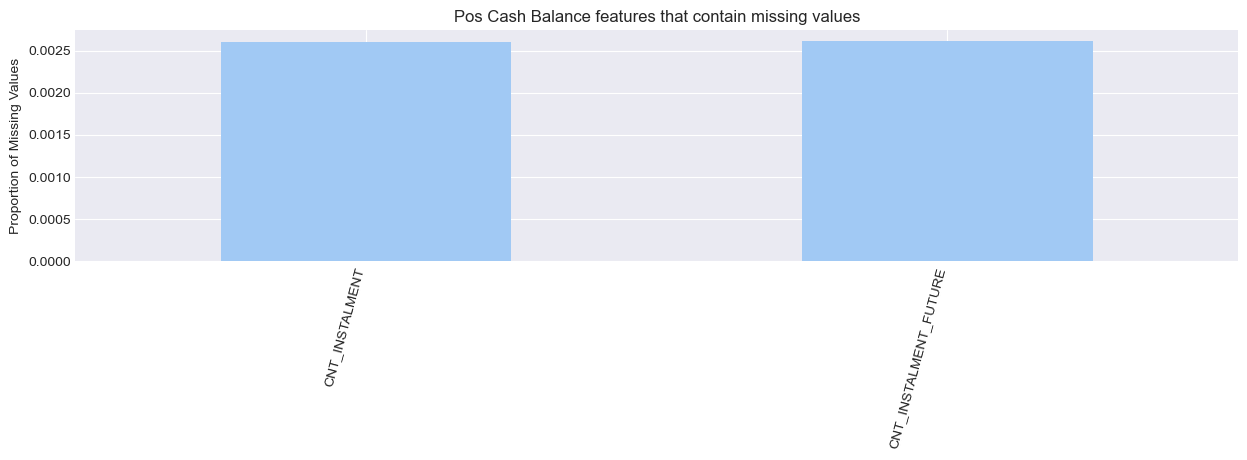

In [170]:
summarize_dataset(
    {
        "Credit Card Balance": credit_card_balance,
        "Pos Cash Balance": pos_cash_balance,
    }
)

Credit_card_balance contains monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

pos_cash_balance contains monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows

## Home Credit Columns Description

 Shape: (219, 5), Null Values: 12.1%

,Id,Table,Row,Description,Special
130,133,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...,NaN
209,212,previous_application.csv,DAYS_TERMINATION,Relative to application date of current applic...,time only relative to the application


,Id,Table,Row,Description,Special
count,219.000000,219,219,219,86
unique,NaN,7,196,163,7
top,NaN,application_{train|test}.csv,SK_ID_CURR,Normalized information about building where th...,normalized
freq,NaN,122,6,47,53
mean,111.981735,NaN,NaN,NaN,NaN
std,63.395726,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN
25%,57.500000,NaN,NaN,NaN,NaN
50%,112.000000,NaN,NaN,NaN,NaN
75%,166.500000,NaN,NaN,NaN,NaN


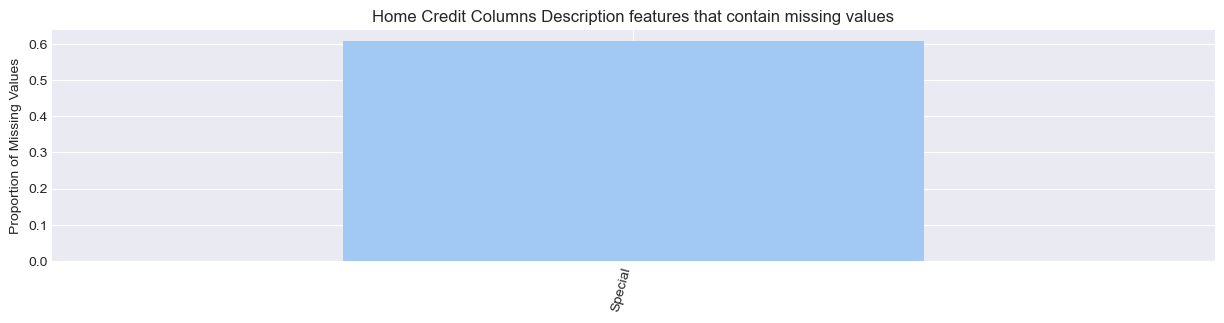

In [171]:
summarize_dataset(
    {
        "Home Credit Columns Description": home_credit_columns_description,
    }
)

This dataset can be used to better understand any feature from the previous datasets

# Analysis

The Kernels [Home Credit Default Risk Competition - A Gentle Introduction](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Exploratory-Data-Analysis) and [LightGBM with Simple Features](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) were used for the exploratory analysis and feature engineering steps. 

We will take a closer look at the application_train dataset. 

We can start by analyzing the target variable to see the ratio of loans that were repaid on time vs those that weren't 

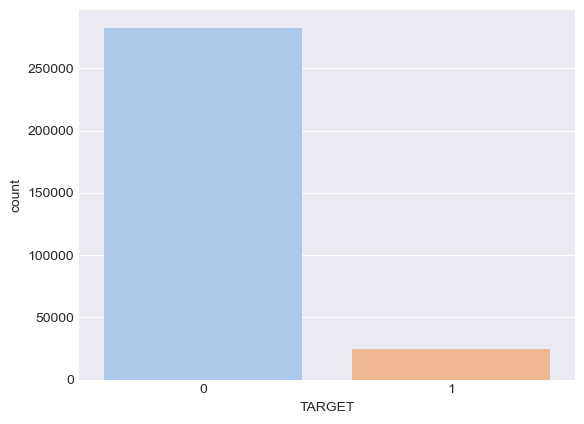

Out of the 307511 current applications, 282686 were repaid on time, meaning 8.07% were not.


In [172]:
target_count = application_train["TARGET"].value_counts()

sns.barplot(y=target_count, x=target_count.index)
plt.show()
print(
    f"Out of the {application_train.shape[0]} current applications, {target_count[0]} were repaid on time, meaning {round(target_count[1]/application_train.shape[0] * 100, 2)}% were not."
)

There is an important imbalance within our target data. We will have to use an oversampling method to balance out the data and prevent overfitting

In order to train a model we will need to encode any categorical features. Let's see how many we have 

In [173]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [174]:
application_train.select_dtypes("object").describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


There are 16 categorical features. They all contain between 2 and 10 unique entries, except for organization_type and occupation_type. 

We will use label encoding for features that contain binary values and one-hot encoding for the others.

In [175]:
label_encoding_features = (
    application_train.select_dtypes("object")
    .loc[:, (application_train.apply(pd.Series.nunique, axis=0)) <= 2]
    .columns
)
label_encoding_features

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

We will inpute the emergency state mode with the most frequent value

In [176]:
application_train["EMERGENCYSTATE_MODE"].fillna("No", inplace=True)
application_test["EMERGENCYSTATE_MODE"].fillna("No", inplace=True)

In [177]:
label_encoder = LabelEncoder()

for feature in label_encoding_features:
    label_encoder.fit(application_train[feature])

    application_train[feature] = label_encoder.transform(
        application_train[feature])
    application_test[feature] = label_encoder.transform(
        application_test[feature])

print("%d columns were label encoded." % len(label_encoding_features))

4 columns were label encoded.


For the other categorical variables we use get_dummies

In [178]:
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print("Training Features shape: ", application_train.shape)
print("Testing Features shape: ", application_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 238)


In [179]:
train_test_feature_diff = [
    item for item in application_train.columns if item not in application_test.columns
]

train_test_feature_diff

['TARGET',
 'CODE_GENDER_XNA',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_FAMILY_STATUS_Unknown']

There are 3 columns in the train set that are not present in the test set due to the encoding since these values were not present in the test set. We will re-align the datasets to ensure that we have the same number of features in both

In [180]:
train_labels = application_train["TARGET"]

application_train, application_test = application_train.align(
    application_test, join="inner", axis=1
)

application_train["TARGET"] = train_labels

print("Training Features shape: ", application_train.shape)
print("Testing Features shape: ", application_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


## Erroneous data

We will replace the erroneous days_employed data with NaN

There are 55374 anomalies in the test data out of 307511 entries


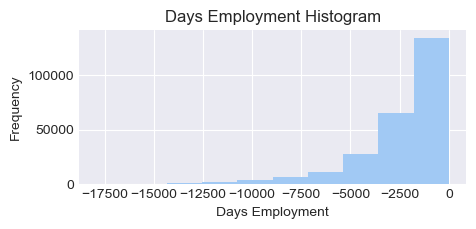

In [181]:
application_train["DAYS_EMPLOYED_ANOM"] = application_train["DAYS_EMPLOYED"] == 365243

application_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
print(
    "There are %d anomalies in the test data out of %d entries"
    % (application_train["DAYS_EMPLOYED_ANOM"].sum(), len(application_train))
)

plt.figure(figsize=[5, 2])
application_train["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment")
plt.show()

In [182]:
application_test["DAYS_EMPLOYED_ANOM"] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

print(
    "There are %d anomalies in the test data out of %d entries"
    % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test))
)

There are 9274 anomalies in the test data out of 48744 entries


## Correlations 

In [183]:
positive_correlation = (
    application_train.corr().sort_values(by="TARGET", ascending=False).head(15)
)
positive_correlation

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET,DAYS_EMPLOYED_ANOM
TARGET,-0.002108,-0.030896,-0.021851,-0.006148,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,...,0.000982,-0.006777,-0.001713,-0.009384,0.000628,-0.033119,-0.012657,0.007946,1.000000,-0.045987
DAYS_BIRTH,-0.001500,0.086364,0.129879,-0.119146,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,...,0.000388,-0.006749,-0.000262,0.004421,-0.000690,-0.013597,-0.010964,0.008758,0.078239,-0.619947
DAYS_EMPLOYED,-0.000084,0.036388,0.023096,-0.030665,0.061145,-0.013005,-0.091295,-0.053604,-0.093374,0.004155,...,0.002030,-0.004689,-0.000801,0.004675,-0.000974,-0.019051,-0.016164,0.007179,0.074958,NaN
REGION_RATING_CLIENT_W_CITY,-0.001138,-0.023116,-0.021405,0.001884,0.024781,-0.091735,-0.110915,-0.141682,-0.112208,-0.531535,...,-0.002086,-0.049740,-0.015432,-0.055445,-0.018756,-0.110948,-0.056365,0.018482,0.060893,0.034755
REGION_RATING_CLIENT,-0.001075,-0.021593,-0.022668,0.001289,0.025423,-0.085465,-0.101776,-0.128525,-0.103786,-0.532877,...,-0.002813,-0.054240,-0.012279,-0.053854,-0.020729,-0.073936,-0.056535,0.025218,0.058899,0.032901
NAME_INCOME_TYPE_Working,-0.002610,0.020789,0.067329,-0.035097,0.136604,-0.024522,-0.056512,-0.043906,-0.057403,-0.115337,...,0.000231,-0.022912,-0.004873,-0.023556,-0.011490,-0.029961,-0.010263,0.007134,0.057481,-0.484189
DAYS_LAST_PHONE_CHANGE,-0.000858,0.061830,-0.039091,0.027019,-0.005865,-0.018585,-0.073701,-0.063747,-0.076313,-0.044013,...,0.001471,-0.004381,-0.003433,-0.001636,0.000068,-0.026314,-0.010363,0.001463,0.055218,0.021111
CODE_GENDER_M,-0.000728,-0.008783,0.345841,-0.044380,0.047382,0.074730,0.021601,0.076994,0.022514,0.014049,...,-0.001102,-0.006391,-0.003936,0.005625,-0.002664,-0.007382,-0.020722,-0.006647,0.054713,-0.157304
DAYS_ID_PUBLISH,-0.000384,0.052847,0.013661,0.006664,-0.028019,0.008506,-0.006575,0.011268,-0.009267,-0.003993,...,0.001282,-0.003078,-0.001923,0.002270,0.001326,-0.015459,-0.005677,0.012702,0.051457,-0.273633
REG_CITY_NOT_WORK_CITY,-0.001582,0.004487,0.076081,-0.061889,0.070650,0.006431,-0.018856,0.000896,-0.020333,-0.044057,...,-0.005461,-0.050688,-0.025127,-0.018427,-0.016880,-0.158786,-0.117382,-0.023462,0.050994,-0.256454


In [184]:
negative_correlation = (
    application_train.corr().sort_values(by="TARGET", ascending=False).tail(15)
)
negative_correlation

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET,DAYS_EMPLOYED_ANOM
ELEVATORS_AVG,0.004862,0.016811,0.036752,-0.000246,-0.007060,0.045053,0.080635,0.101439,0.083736,0.280685,...,-0.032145,-0.058929,0.024063,0.109267,-0.013524,0.286091,-0.250901,-0.097625,-0.034199,-0.009886
REGION_POPULATION_RELATIVE,0.000849,0.026867,0.041314,0.015175,-0.025573,0.074796,0.099738,0.118429,0.103520,1.000000,...,0.011212,0.078062,0.016288,0.045775,0.013435,0.092652,0.010782,-0.056263,-0.037227,-0.004037
AMT_GOODS_PRICE,-0.000232,-0.185850,0.120310,-0.045537,-0.001827,0.159610,0.986968,0.775109,1.000000,0.103520,...,0.000796,0.013696,0.009955,0.028315,0.005877,0.049759,0.012888,-0.009135,-0.039645,-0.063569
HOUSETYPE_MODE_block of flats,0.001254,0.027133,-0.031669,0.022850,-0.036400,0.049553,0.057524,0.066794,0.061923,0.106941,...,-0.061587,0.171562,0.065161,0.076368,0.064754,0.518462,0.484830,0.112854,-0.040594,-0.009131
FLOORSMAX_MODE,0.004386,0.024052,0.046389,0.006630,-0.009550,0.057675,0.100418,0.126302,0.105532,0.303992,...,-0.096824,-0.046745,0.012791,0.209756,-0.035682,0.306029,-0.216690,-0.252245,-0.043226,-0.015121
FLOORSMAX_MEDI,0.004588,0.025363,0.047162,0.005161,-0.009447,0.059682,0.102770,0.129179,0.107936,0.318319,...,-0.091208,-0.039246,0.011272,0.215567,-0.033533,0.298369,-0.214576,-0.249825,-0.043768,-0.016118
FLOORSMAX_AVG,0.004851,0.025687,0.047174,0.004989,-0.009705,0.060171,0.103296,0.130174,0.108512,0.322652,...,-0.091380,-0.039307,0.011809,0.215378,-0.034115,0.300087,-0.216017,-0.250162,-0.044003,-0.016038
ORGANIZATION_TYPE_XNA,0.001368,-0.054967,-0.154778,0.070107,-0.240722,-0.064038,-0.065594,-0.103608,-0.063569,-0.004037,...,-0.001789,0.003755,-0.003681,-0.006957,-0.003107,-0.003935,-0.006108,-0.002945,-0.045987,1.000000
DAYS_EMPLOYED_ANOM,0.001368,-0.054967,-0.154778,0.070107,-0.240722,-0.064038,-0.065594,-0.103608,-0.063569,-0.004037,...,-0.001789,0.003755,-0.003681,-0.006957,-0.003107,-0.003935,-0.006108,-0.002945,-0.045987,1.000000
NAME_INCOME_TYPE_Pensioner,0.001399,-0.054852,-0.154826,0.070155,-0.240719,-0.064018,-0.065753,-0.103721,-0.063736,-0.004044,...,-0.001783,0.003724,-0.003673,-0.006839,-0.003100,-0.003964,-0.006076,-0.002931,-0.046209,0.999648


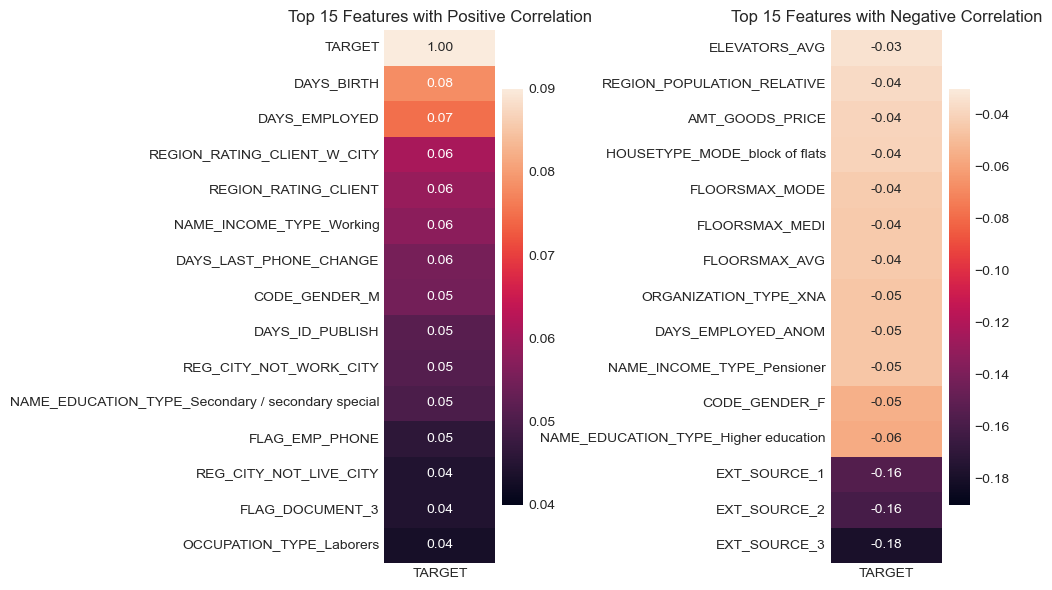

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.heatmap(
    positive_correlation[["TARGET"]],
    annot=True,
    fmt=".2f",
    ax=axs[0],
    vmin=0.04,
    vmax=0.09,
)
sns.heatmap(
    negative_correlation[["TARGET"]],
    annot=True,
    fmt=".2f",
    ax=axs[1],
    vmin=-0.19,
    vmax=-0.03,
)

axs[0].set_title("Top 15 Features with Positive Correlation")
axs[1].set_title("Top 15 Features with Negative Correlation")

plt.tight_layout()
plt.show()

The most highly correlated features are days_birth and ext_source 

In [186]:
application_train["DAYS_BIRTH"]

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

Since the days_birth values are negative, there is a negative linear relationship between age and the target variable, meaning as age increases the target decreases. Therefore older clients are more likely to repay their loans on time.

In [187]:
application_train["DAYS_BIRTH"] = abs(application_train["DAYS_BIRTH"])

Text(0, 0.5, 'Count')

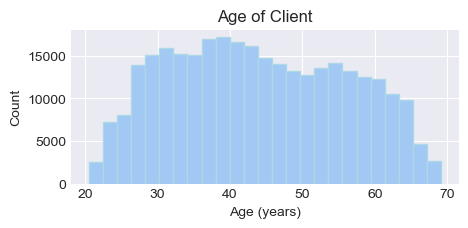

In [188]:
plt.figure(figsize=(5, 2))

plt.hist(application_train["DAYS_BIRTH"] / 365, edgecolor="lightblue", bins=25)
plt.title("Age of Client")
plt.xlabel("Age (years)")
plt.ylabel("Count")

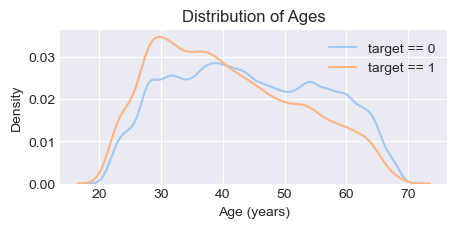

In [189]:
plt.figure(figsize=(5, 2))
sns.kdeplot(
    application_train.loc[application_train["TARGET"]
                          == 0, "DAYS_BIRTH"] / 365,
    label="target == 0",
)
sns.kdeplot(
    application_train.loc[application_train["TARGET"]
                          == 1, "DAYS_BIRTH"] / 365,
    label="target == 1",
)
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.title("Distribution of Ages")
plt.legend()
plt.show()

This KDE plot clearly illustrates the effect of age on loan repayment. As age increases, the orange line which represents loans with default payments decreases.

In [190]:
age_data = application_train[["TARGET", "DAYS_BIRTH"]]
age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / 365

age_data["YEARS_BINNED"] = pd.cut(
    age_data["YEARS_BIRTH"], bins=np.linspace(20, 70, num=11)
)
age_groups = age_data.groupby("YEARS_BINNED").mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

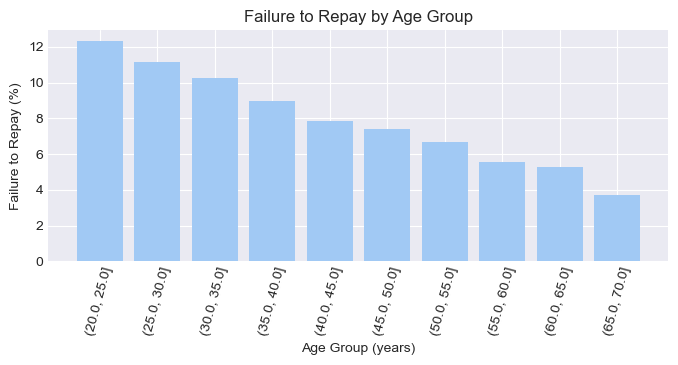

In [191]:
plt.figure(figsize=(8, 3))
plt.bar(age_groups.index.astype(str), 100 * age_groups["TARGET"])
plt.xticks(rotation=75)
plt.xlabel("Age Group (years)")
plt.ylabel("Failure to Repay (%)")
plt.title("Failure to Repay by Age Group")

The trend gets even when grouping clients by age. The percentage of failure to repay steadily decreases as age increases

In [192]:
home_credit_columns_description.loc[
    home_credit_columns_description["Row"].isin(
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
    )
]

,Id,Table,Row,Description,Special
41,44,application_{train|test}.csv,EXT_SOURCE_1,Normalized score from external data source,normalized
42,45,application_{train|test}.csv,EXT_SOURCE_2,Normalized score from external data source,normalized
43,46,application_{train|test}.csv,EXT_SOURCE_3,Normalized score from external data source,normalized


The second highest correlation is the EXT_SOURCE feature which seems to represent some sort of score. 

In [193]:
ext_data = application_train[
    ["TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH"]
]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


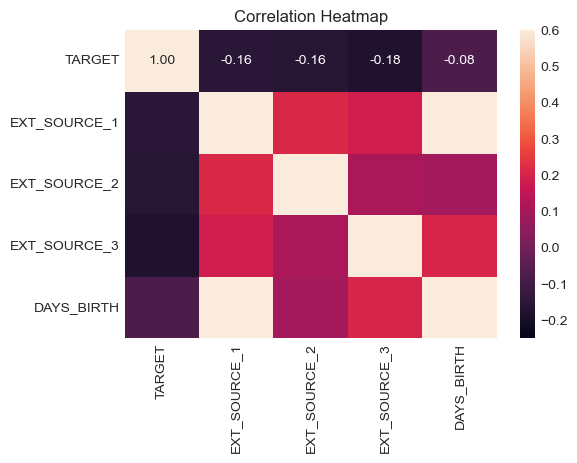

In [194]:
plt.figure(figsize=(6, 4))

sns.heatmap(ext_data_corrs, annot=True, fmt=".2f", vmin=-0.25, vmax=0.6)
plt.title("Correlation Heatmap")
plt.show()

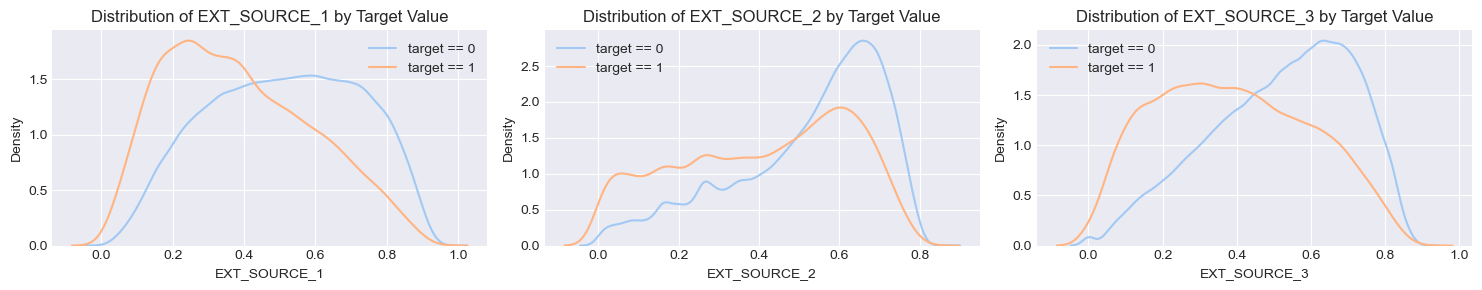

In [195]:
plt.figure(figsize=(15, 3))

for i, source in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(
        application_train.loc[application_train["TARGET"] == 0, source],
        label="target == 0",
    )
    sns.kdeplot(
        application_train.loc[application_train["TARGET"] == 1, source],
        label="target == 1",
    )
    plt.title("Distribution of %s by Target Value" % source)
    plt.xlabel("%s" % source)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

There is a weak negative correlation between ext_source and the target, suggesting that as the score increases, the more likely it is that the loan will be repaid on time. 

## Feature Engineering 

Creating 4 features that might be helpful in representing a client's credit profile and thus his ability to repay or not a loan : 

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [196]:
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

app_train_domain["CREDIT_INCOME_PERCENT"] = (
    app_train_domain["AMT_CREDIT"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["ANNUITY_INCOME_PERCENT"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["CREDIT_TERM"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_CREDIT"]
)
app_train_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_train_domain["DAYS_EMPLOYED"] / app_train_domain["DAYS_BIRTH"]
)

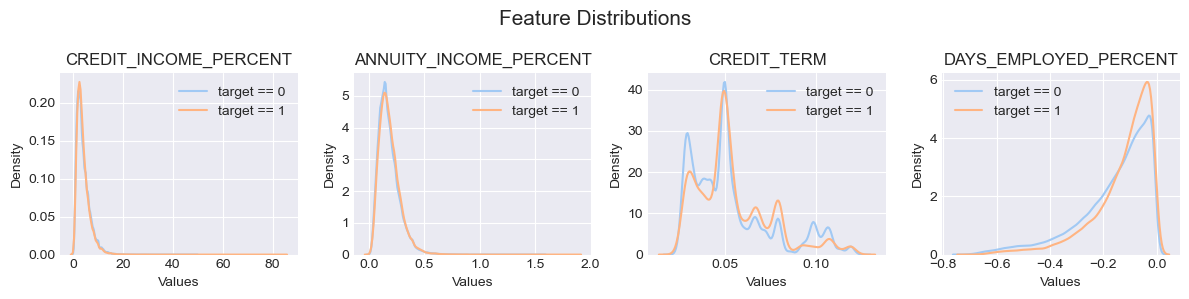

In [197]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, column in enumerate(
    [
        "CREDIT_INCOME_PERCENT",
        "ANNUITY_INCOME_PERCENT",
        "CREDIT_TERM",
        "DAYS_EMPLOYED_PERCENT",
    ]
):
    ax = axes[i]

    sns.kdeplot(
        app_train_domain.loc[app_train_domain["TARGET"] == 0, column],
        label="target == 0",
        ax=ax,
    )
    sns.kdeplot(
        app_train_domain.loc[app_train_domain["TARGET"] == 1, column],
        label="target == 1",
        ax=ax,
    )

    ax.set_title(f"{column}")
    ax.set_xlabel("Values")
    ax.set_ylabel("Density")
    ax.legend()

fig.suptitle("Feature Distributions", fontsize=15)
plt.tight_layout()
plt.show()

We can now impute missing values with the median using a SimpleImputer

In [198]:
app_train = application_train.copy()
app_y_train = application_train["TARGET"]
app_train = application_train.drop(columns=["TARGET"])
app_test = application_test.copy()

features = list(app_train.columns)

imputer = SimpleImputer(strategy="median")
imputer.fit(app_train)
app_train = imputer.transform(app_train)
app_test = imputer.transform(app_test)

 # Modeling 

## Logistic Regression - baseline

### Preprocessing

We start by using a MinMaxScaler to normalize the range of the features

In [199]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(app_train)
app_train_scaled = scaler.transform(app_train)
app_test_scaled = scaler.transform(app_test)

print("Training data shape: ", app_train_scaled.shape)
print("Testing data shape: ", app_test_scaled.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


We then split the data into training and test sets 

In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train, app_y_train, test_size=0.2, random_state=42
)

Before being able to train the model, we need to tackle the imbalance issue in the data set. 

In order to solve this problem, we will use the Synthetic Minority Oversampling Technique (SMOTE), coupled with an undersampling method.  

### SMOTE - Under and Over sampling 

In [201]:
print(sum(y_train == 0), "individuals are category 0 before applying SMOTE")
print(sum(y_train == 1), "individuals are category 1 before applying SMOTE")

226132 individuals are category 0 before applying SMOTE
19876 individuals are category 1 before applying SMOTE


In [202]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(sum(y_train_smote == 0), "individuals are category 0 after over sampling")
print(sum(y_train_smote == 1), "individuals are category 1 after over sampling")

226132 individuals are category 0 after over sampling
226132 individuals are category 1 after over sampling


In [203]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_smote, y_train_smote = under_sampler.fit_resample(X_train, y_train)

print(sum(y_train_smote == 0), "individuals are category 0 after under sampling")
print(sum(y_train_smote == 1), "individuals are category 1 after under sampling")

19876 individuals are category 0 after under sampling
19876 individuals are category 1 after under sampling


The dataset is now properly balanced

### Training

In [204]:
from sklearn.linear_model import LogisticRegression

mlflow.set_tracking_uri("http://127.0.0.1:8080/")
mlflow.start_run()
C = 0.0001
logistic_regression = LogisticRegression(C=C)
logistic_regression.fit(X_train, y_train)

predicted_probabilities = logistic_regression.predict_proba(X_test)[:, 1]
predicted = logistic_regression.predict(X_test)

### Metrics

To evaluate the model we can use the existing AUC and Accuracy metrics 

In [205]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(3, 3))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Training Data)")
    plt.legend(loc="lower right")
    plt.savefig(f"plots/ROC_curve_{roc_auc:.4f}.png")
    plt.show()


def roc(actual, predicted, plot=False):
    fpr, tpr, thresholds = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)
    if plot == True:
        plot_roc_curve(fpr, tpr, roc_auc)
    return roc_auc

In order to provide the best solution for our business needs, we need to calculate a score that reflects the cost imbalance between false negatives and false positives. 

We assume that the cost of a false negative (a client who was granted a loan but will not be able to repay it) is 10 times higher than that of a false positive (a client who would have been able to repay the loan but was not granted one). 

We can use the results of this initial LogisticRegression to find the best threshold to evaluate and compare models and find the best hyperparameters

In [206]:
def calculate_confusion_matrix_at_threshold(
    true_labels, predicted_probabilities, threshold
):
    binary_predictions = (predicted_probabilities > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(true_labels, binary_predictions).ravel()
    return tn, fp, fn, tp


def find_best_threshold_for_minimal_business_cost(true_labels, predicted_probabilities):
    # thresholds to test
    thresholds = [i / 100 for i in range(10, 101, 5)]
    best_threshold = None
    min_cost = float("inf")

    for threshold in thresholds:
        tn, fp, fn, tp = calculate_confusion_matrix_at_threshold(
            true_labels, predicted_probabilities, threshold
        )
        business_cost = fn * 10 + fp
        if business_cost < min_cost:
            min_cost = business_cost
            best_threshold = threshold

    print(f"Best Threshold: {best_threshold}")

    # make final predictions based on optimal threshold
    final_binary_predictions = (predicted_probabilities > best_threshold).astype(int)

    # calculate metrics with the best threshold
    accuracy = accuracy_score(true_labels, final_binary_predictions)
    print(f"Accuracy with Best Threshold: {accuracy:.2%}")

    return best_threshold


def calculate_business_score(actual, predicted_probabilities):
    best_threshold = find_best_threshold_for_minimal_business_cost(
        actual, predicted_probabilities
    )
    tn, fp, fn, tp = calculate_confusion_matrix_at_threshold(
        actual, predicted_probabilities, best_threshold
    )
    business_cost = fn * 10 + fp
    # maximal cost would be if all predictions are false negatives
    max_possible_cost = len(actual) * 10
    return 1 - business_cost / max_possible_cost

In [207]:
def evaluation_metrics(actual, predicted_probabilities, predicted, plot=False):
    roc_auc = roc(actual, predicted_probabilities, plot)
    accuracy = accuracy_score(actual, predicted)
    business_score = calculate_business_score(y_test, predicted_probabilities)

    print(f"Business Score: {business_score:.2}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"AUC: {roc_auc:.2}")
    return accuracy, roc_auc, business_score

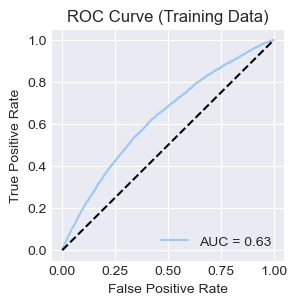

Best Threshold: 0.1
Accuracy with Best Threshold: 68.97%
Business Score: 0.93
Accuracy: 91.95%
AUC: 0.63


In [208]:
accuracy, roc_auc, business_score = evaluation_metrics(
    y_test, predicted_probabilities, predicted, True
)

mlflow.log_param("C", C)
mlflow.log_metric("roc_auc", roc_auc)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_artifact(f"plots/ROC_curve_{roc_auc:.4f}.png")
mlflow.log_metric("business_score", business_score)
mlflow.end_run()

This test suggests that the best threshold to minimise business costs is 0.1. In other words, this very low thresholds will yield more positives and therefore false positives, which will in turn decrease the likelyhood of getting false negatives which we indicated was more detrimental for our business. 

In order to better evaluate and compare different models, we will use cross-validation and hyperparameter optimization by using GridsearchCV. 

The optimal hyperparameters will be selected based on the business score.

We can now try the LogisticRegression model with the data that was balanced using SMOTE

In [209]:
mlflow.start_run()
C = 0.0001
logistic_regression = LogisticRegression(C=C)
logistic_regression.fit(X_train_smote, y_train_smote)

predicted_probabilities = logistic_regression.predict_proba(X_test)[:, 1]
predicted = logistic_regression.predict(X_test)

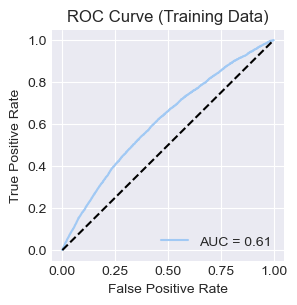

Best Threshold: 0.5
Accuracy with Best Threshold: 60.53%
Business Score: 0.93
Accuracy: 60.53%
AUC: 0.61


In [210]:
accuracy, roc_auc, business_score = evaluation_metrics(
    y_test, predicted_probabilities, predicted, True
)

mlflow.log_param("C", C)
mlflow.log_metric("roc_auc", roc_auc)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("business_score", business_score)
mlflow.log_artifact(f"plots/ROC_curve_{roc_auc:.4f}.png")
mlflow.end_run()

We can see that both accuracy and AUC scores decreased following the data under and over sampling using SMOTE. These score are now more reliable than those that resulted from an imbalanced data set. 

We can also note that the business score decreased as well, which is what we aim for. 

## GridsearchCV 

In [211]:
import time


def build_pipeline(model):
    over = SMOTE()
    under = RandomUnderSampler()
    steps = [
        ("over", over),
        ("under", under),
        ("scaler", MinMaxScaler()),
        ("model", model),
    ]
    return Pipeline(steps=steps)


def grid_search(X, y, model, params):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "roc_auc": make_scorer(roc, needs_proba=True),
        "business_score": make_scorer(calculate_business_score, needs_proba=True),
    }

    mlflow.start_run()

    start = time.time()
    grid = GridSearchCV(
        build_pipeline(model),
        params,
        cv=5,
        scoring=scoring,
        refit="business_score",
        n_jobs=4,
    )
    grid.fit(X_train, y_train)
    y_predicted = grid.predict(X_test)
    y_predicted_probabilities = grid.predict_proba(X_test)[:, 1]

    accuracy, roc_auc, business_score = evaluation_metrics(
        y_test, y_predicted_probabilities, y_predicted
    )

    grid_results = grid.cv_results_
    elapsed_time = time.time() - start

    for best_param, value in grid.best_params_.items():
        mlflow.log_param(best_param, value)
    mlflow.sklearn.log_model(sk_model=grid.best_estimator_, artifact_path=str(model)[:-2])
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("business_score", business_score)
    mlflow.log_metric("elapsed_time", elapsed_time)

    mlflow.log_metric("mean_roc_auc", grid_results["mean_test_roc_auc"].mean())
    mlflow.log_metric("mean_accuracy", grid_results["mean_test_accuracy"].mean())
    mlflow.log_metric(
        "mean_business_score", grid_results["mean_test_business_score"].mean()
    )
    mlflow.end_run()

### LogisticRegression

In [212]:
param_grid = {
    "model__C": [0.0001, 0.001, 0.01],
    "model__random_state": [42],
}

grid_search(app_train, app_y_train, LogisticRegression(), param_grid)

Best Threshold: 0.5
Accuracy with Best Threshold: 65.92%
Best Threshold: 0.55
Accuracy with Best Threshold: 76.26%
Best Threshold: 0.5
Accuracy with Best Threshold: 65.71%
Best Threshold: 0.55
Accuracy with Best Threshold: 76.04%
Best Threshold: 0.5
Accuracy with Best Threshold: 65.89%
Best Threshold: 0.55
Accuracy with Best Threshold: 74.95%
Best Threshold: 0.55
Accuracy with Best Threshold: 74.70%
Best Threshold: 0.5
Accuracy with Best Threshold: 68.41%
Best Threshold: 0.5
Accuracy with Best Threshold: 68.89%
Best Threshold: 0.5
Accuracy with Best Threshold: 68.96%


/Users/amelie-dzovinar/Dev/anaconda3/envs/p7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Threshold: 0.5
Accuracy with Best Threshold: 69.16%


/Users/amelie-dzovinar/Dev/anaconda3/envs/p7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Threshold: 0.55
Accuracy with Best Threshold: 73.87%


/Users/amelie-dzovinar/Dev/anaconda3/envs/p7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Threshold: 0.55
Accuracy with Best Threshold: 74.30%


/Users/amelie-dzovinar/Dev/anaconda3/envs/p7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Threshold: 0.55
Accuracy with Best Threshold: 74.29%


/Users/amelie-dzovinar/Dev/anaconda3/envs/p7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Threshold: 0.5
Accuracy with Best Threshold: 69.40%
Best Threshold: 0.55
Accuracy with Best Threshold: 74.12%
Business Score: 0.95
Accuracy: 68.98%
AUC: 0.75


### LightGBM 

In [213]:
from lightgbm import LGBMClassifier

In [221]:
param_grid = {
    "model__num_leaves": [15, 31, 80, 200],
    "model__max_depth": [6, 8, 10],
    "model__random_state": [42],
}

grid_search(app_train, app_y_train, LGBMClassifier(), param_grid)

[LightGBM] [Info] Number of positive: 180905, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52243
[LightGBM] [Info] Number of data points in the train set: 361810, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 180906, number of negative: 180906
[LightGBM] [Info] Number of positive: 180906, number of negative: 180906
[LightGBM] [Info] Number of positive: 180905, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52328
[LightGBM] [

### RandomForestClassifier

In [222]:
param_grid = {
    "model__n_estimators": [80, 100, 120],
    "model__min_samples_split": [2, 4, 6, 8],
    "model__criterion": [
        "gini",
        "entropy",
        "log_loss",
    ],
    "model__random_state": [42],
}

grid_search(app_train, app_y_train, RandomForestClassifier(), param_grid)

Best Threshold: 0.15
Accuracy with Best Threshold: 77.77%
Best Threshold: 0.15
Accuracy with Best Threshold: 78.02%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.24%
Best Threshold: 0.1
Accuracy with Best Threshold: 60.40%
Best Threshold: 0.15
Accuracy with Best Threshold: 78.04%
Best Threshold: 0.1
Accuracy with Best Threshold: 60.01%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.77%
Best Threshold: 0.1
Accuracy with Best Threshold: 59.93%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.79%
Best Threshold: 0.1
Accuracy with Best Threshold: 60.08%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.55%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.62%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.89%
Best Threshold: 0.15
Accuracy with Best Threshold: 76.06%
Best Threshold: 0.15
Accuracy with Best Threshold: 77.96%
Best Threshold: 0.15
Accuracy with Best Threshold: 78.01%
Best Threshold: 0.15
Accuracy with Best Threshold: 75.93%
Best Threshold: 0.